### Initialisation maps

#### Libraries

In [1]:
import numpy as np
import xarray as xr
import csv
import pandas as pd

import functions_py.fates_xarray_functions as fa
import functions_py.fates_nearest_gridcell as ngr

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm


In [2]:
dark = cm.get_cmap('Dark2', 8)
colormap = dark(range(8))

In [3]:
pfts = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']

In [4]:
w = [  2,   2,   6, -10,  10,   6,  10, -18, -14,  -6,  10, -14,  -2,
        18,  14,  14, -18]
z = [ 25,  30, 355,  35, 285, 295, 275, 315, 295, 310, 295, 305, 280,
       100, 100,  75, 145]
lat_un = xr.DataArray(w, dims = ['location']).astype(int)
lon_un = xr.DataArray(z, dims = ['location']).astype(int)

#### Load all the variations

In [5]:
# atkin - control - initialised with large size
fates_atkin = '/compyfs/need138/elm_runs/fixedbiogeog_nocomp_Atkin_init_dbh.Eb645be3-F0a36a4c.2023-02-28/run/lnd/hist/fixedbiogeog_nocomp_Atkin_init_dbh.Eb645be3-F0a36a4c.2023-02-28.elm.h0.2000s.nc'
fates_atkin = xr.open_dataset(fates_atkin, decode_times=False)
time = fates_atkin.variables['time']/365.

n_lat = len(fates_atkin.variables['lat'])
n_lon = len(fates_atkin.variables['lon'])
cohort_size_bins = fates_atkin.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)

nyears = int(len(fates_atkin.variables['time'])/12)
time = fates_atkin.variables['time'] / 365.

# atkin - init dbh pure PPA
fates_atkin_v2 = '/compyfs/need138/elm_runs/fixedbiogeog_nocomp_Atkin_ppa_init_dbh.Eb645be3-F0a36a4c.2023-02-28/run/lnd/hist/fixedbiogeog_nocomp_Atkin_ppa_init_dbh.Eb645be3-F0a36a4c.2023-02-28.elm.h0.2000s.nc'
fates_atkin_v2 = xr.open_dataset(fates_atkin_v2, decode_times=False)
time_v2 = fates_atkin_v2.variables['time']/365.

# atkin - init dbh high soil moisture
fates_atkin_v3 = '/compyfs/need138/elm_runs/fixedbiogeog_nocomp_Atkin_high_soilmoisture_dbh_init.Eb645be3-F0a36a4c.2023-02-28/run/lnd/hist/fixedbiogeog_nocomp_Atkin_high_soilmoisture_dbh_init.Eb645be3-F0a36a4c.2023-02-28.elm.h0.2000s.nc'
fates_atkin_v3 = xr.open_dataset(fates_atkin_v3, decode_times=False)
time_v3 = fates_atkin_v3.variables['time']/365.

print(len(time))
print(len(time_v3))
print(len(time_v2))


120
115
115


#### Vegc in year 10 

In [6]:
vegc_atkin = fates_atkin.FATES_VEGC.isel(time=slice(102,114)).mean(dim='time')
vegc_atkin_v2 = fates_atkin_v2.FATES_VEGC.isel(time=slice(102,114)).mean(dim='time')
vegc_atkin_v3 = fates_atkin_v3.FATES_VEGC.isel(time=slice(102,114)).mean(dim='time')


Text(0.5, 1.0, 'DBH init - pure PPA')

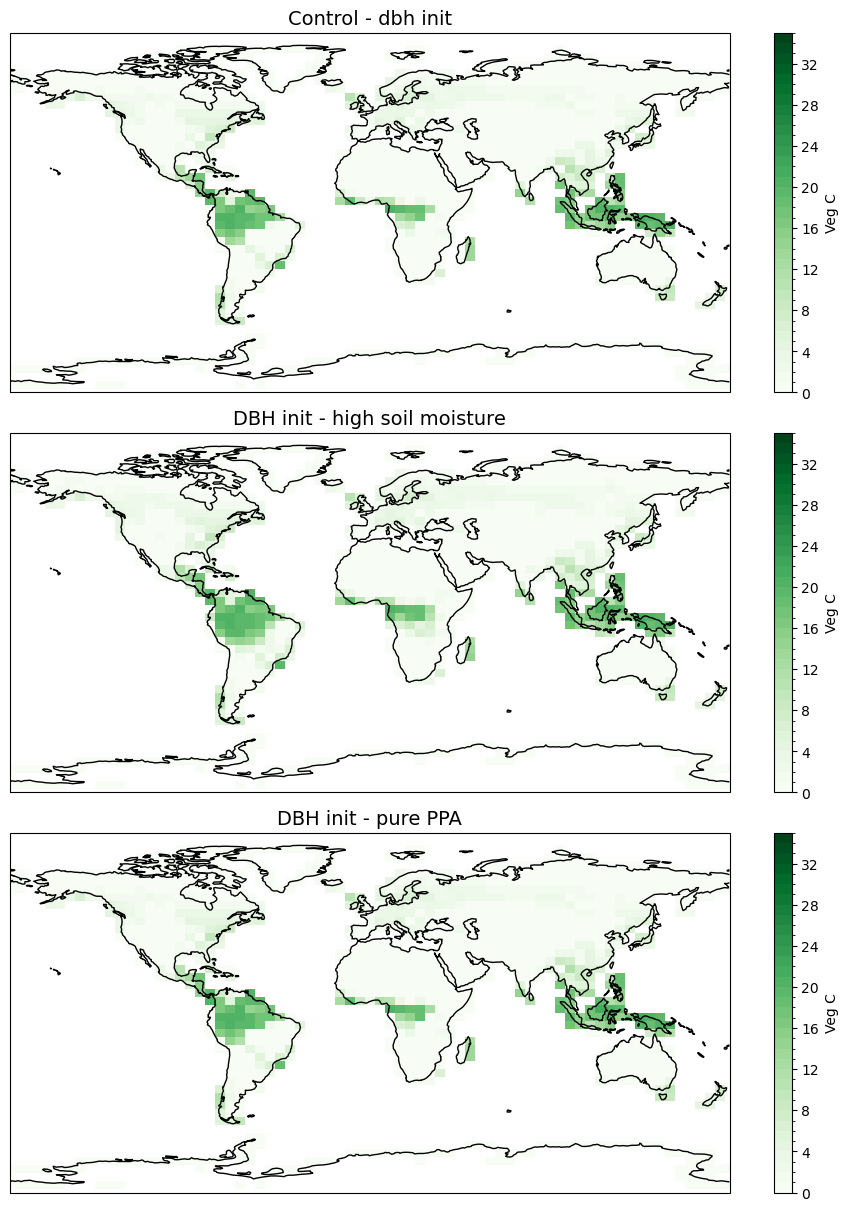

In [7]:
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,12), constrained_layout=True)

axs = axs.flatten()

clevs = np.arange(0.,36,1.0)

vegc_atkin.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "Veg C"}, ax=axs[0])
axs[0].coastlines()
axs[0].set_title('Control - dbh init', fontsize=14)

vegc_atkin_v3.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "Veg C"}, ax=axs[1])
axs[1].coastlines()
axs[1].set_title('DBH init - high soil moisture', fontsize=14)

vegc_atkin_v2.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "Veg C"}, ax=axs[2])
axs[2].coastlines()
axs[2].set_title('DBH init - pure PPA', fontsize=14)


### Veg C through time in the problem grid cells

##### Higher soil moisture prevents extinction in some of the grid cells

In [8]:
vegc_atkin = fates_atkin.FATES_VEGC
vegc_atkin = vegc_atkin.sel(lat=lat_un,lon=lon_un)

vegc_atkin_v2 = fates_atkin_v2.FATES_VEGC
vegc_atkin_v2 = vegc_atkin_v2.sel(lat=lat_un,lon=lon_un)

vegc_atkin_v3 = fates_atkin_v3.FATES_VEGC
vegc_atkin_v3 = vegc_atkin_v3.sel(lat=lat_un,lon=lon_un)


Text(0.02, 0.5, 'Veg C')

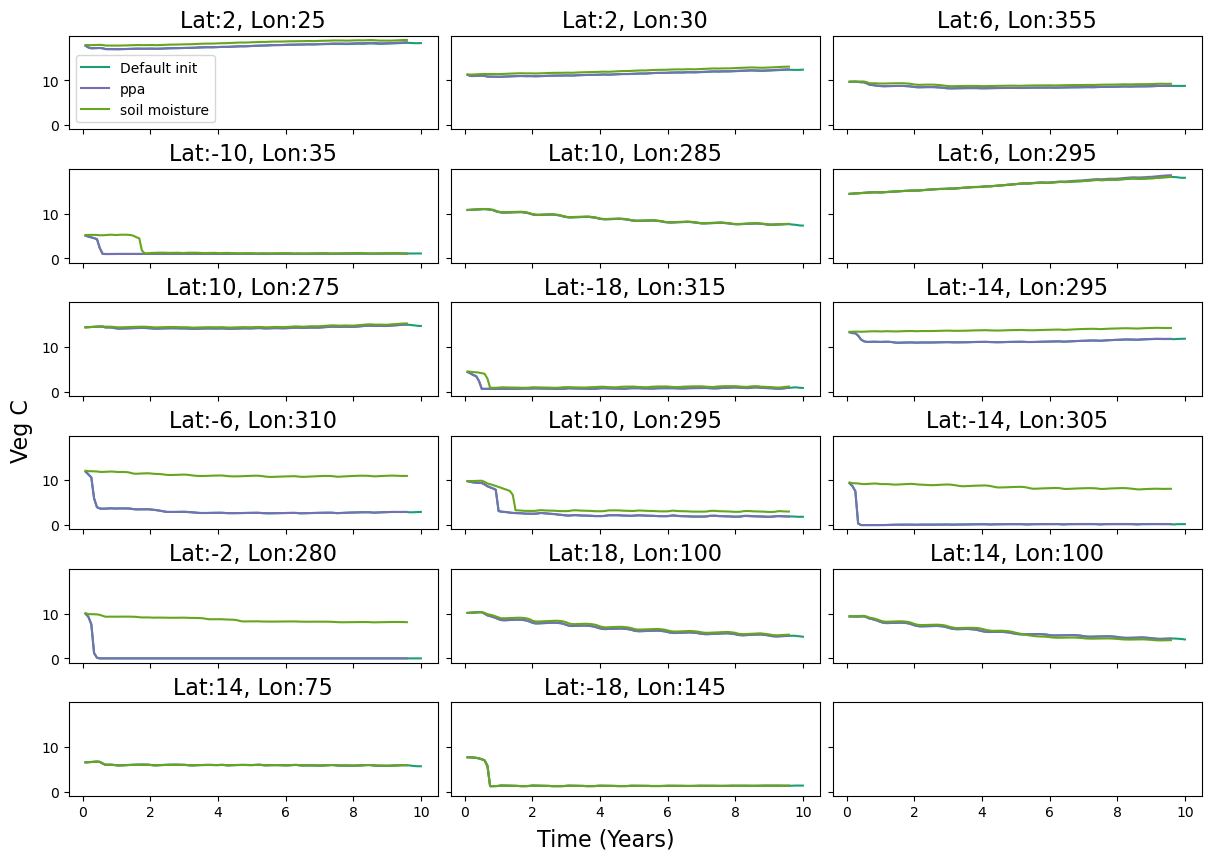

In [9]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        figsize=(12,8.5), sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,17):
    axs[i].plot(time, vegc_atkin[:,i], label='Default init', color=colormap[0])
    axs[i].plot(time_v2, vegc_atkin_v2[:,i], label='ppa', color=colormap[2])
    axs[i].plot(time_v3, vegc_atkin_v3[:,i], label='soil moisture', color=colormap[4])
    axs[i].set_title(r'Lat:{0}, Lon:{1}'.format(w[i],z[i]), fontsize = 16)
    if i == 0 :
        axs[i].legend()
    
    
fig.supxlabel(r'Time (Years)', fontsize=16)
fig.supylabel(r'Veg C', fontsize=16)

### Mortality in high soil moisture run

### Soil moisture in the default case

Text(0.5, 1.0, 'Soil Water 10 cm')

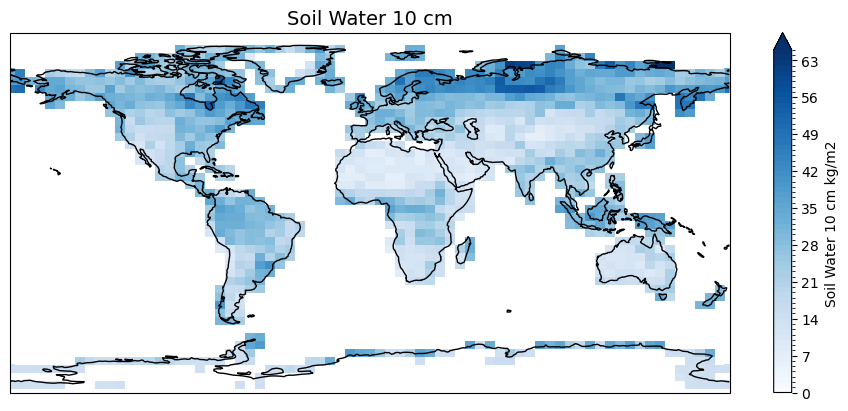

In [10]:
soil_moisture = fates_atkin.SOILWATER_10CM.mean('time') 

fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,4), constrained_layout=True)


clevs = np.arange(0.,66,1.)

soil_moisture.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Blues',
         cbar_kwargs={"label": "Soil Water 10 cm kg/m2 "}, ax=axs)
axs.coastlines()
axs.set_title('Soil Water 10 cm', fontsize=14)



### ... and in the problem grid cells

In [11]:
SM = fates_atkin.SOILWATER_10CM
SM = SM.sel(lat=lat_un,lon=lon_un)


Text(0.02, 0.5, 'Soil Water 10 cm')

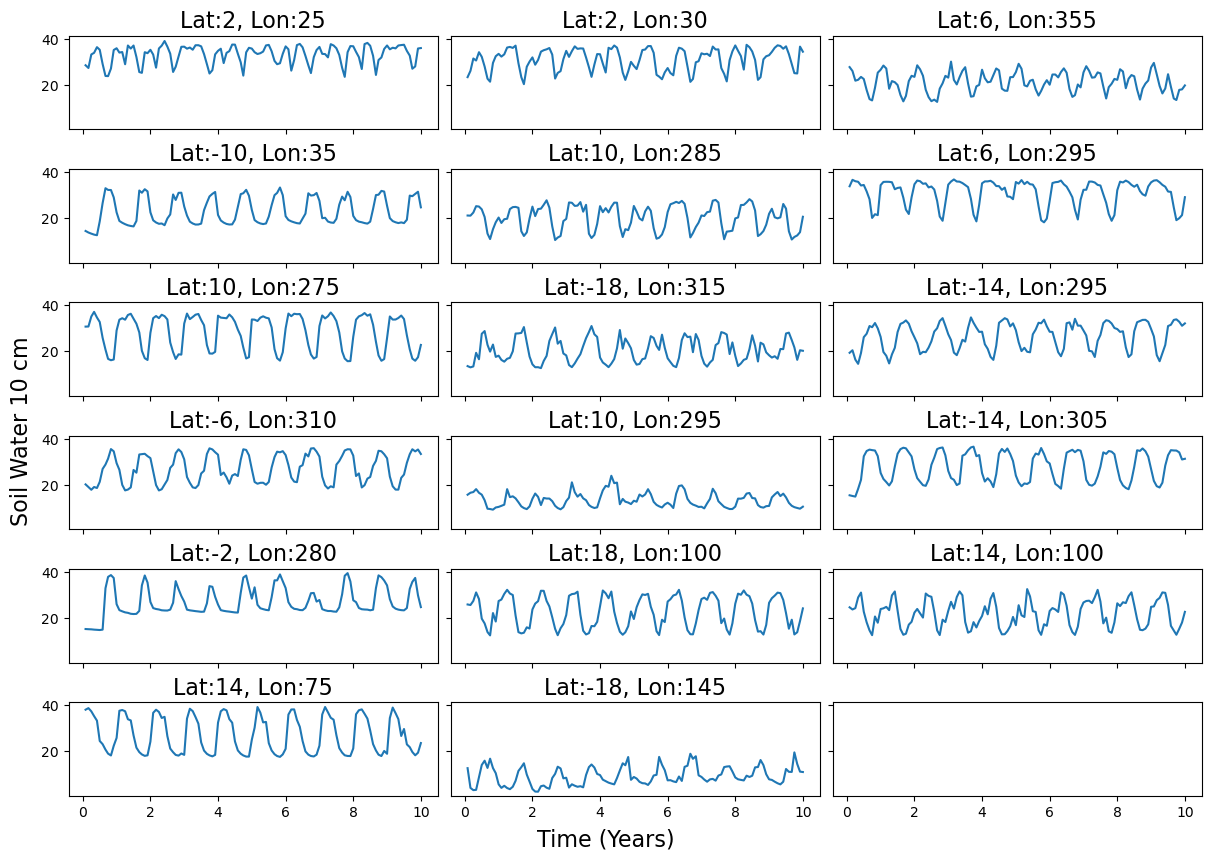

In [12]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        figsize=(12,8.5), sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,17):
    axs[i].plot(time, SM[:,i])
    axs[i].set_title(r'Lat:{0}, Lon:{1}'.format(w[i],z[i]), fontsize = 16)
   
    
fig.supxlabel(r'Time (Years)', fontsize=16)
fig.supylabel(r'Soil Water 10 cm', fontsize=16)


### Volumetric soil moisture in problem grid cells

In [13]:
h2osoi = fates_atkin.H2OSOI.sum('levgrnd')
h2osoi = h2osoi.sel(lat=lat_un,lon=lon_un)


Text(0.02, 0.5, 'volumetric soil water mm3/mm3')

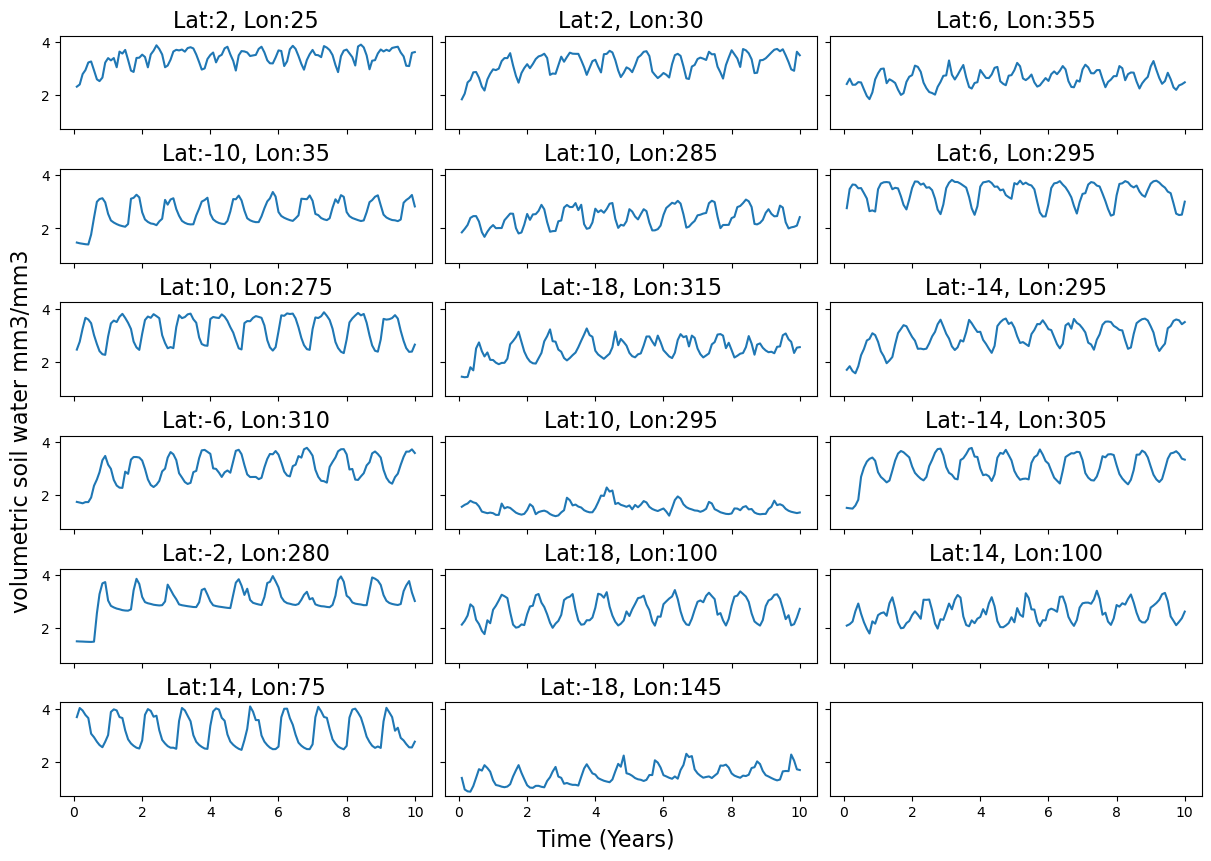

In [14]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        figsize=(12,8.5), sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,17):
    axs[i].plot(time, h2osoi[:,i])
    axs[i].set_title(r'Lat:{0}, Lon:{1}'.format(w[i],z[i]), fontsize = 16)
   
    
fig.supxlabel(r'Time (Years)', fontsize=16)
fig.supylabel(r'volumetric soil water mm3/mm3', fontsize=16)


### SP mode GPP in problem grid cells

In [15]:
fates_atkin_SP = '/compyfs/need138/elm_runs/spmode_atkin_newvertprof.Ec63cce2-F76adbb7.2022-11-22/run/lnd/hist/spmode_atkin_newvertprof.Ec63cce2-F76adbb7.2022-11-22.elm.h0.fullrun.nc'
fates_atkin_SP = xr.open_dataset(fates_atkin_SP, decode_times=False)

timeSP = fates_atkin_SP.variables['time'] / 365.
print(len(timeSP))

120


Text(0.02, 0.5, 'SP mode GPP kg C m-2 yr-1')

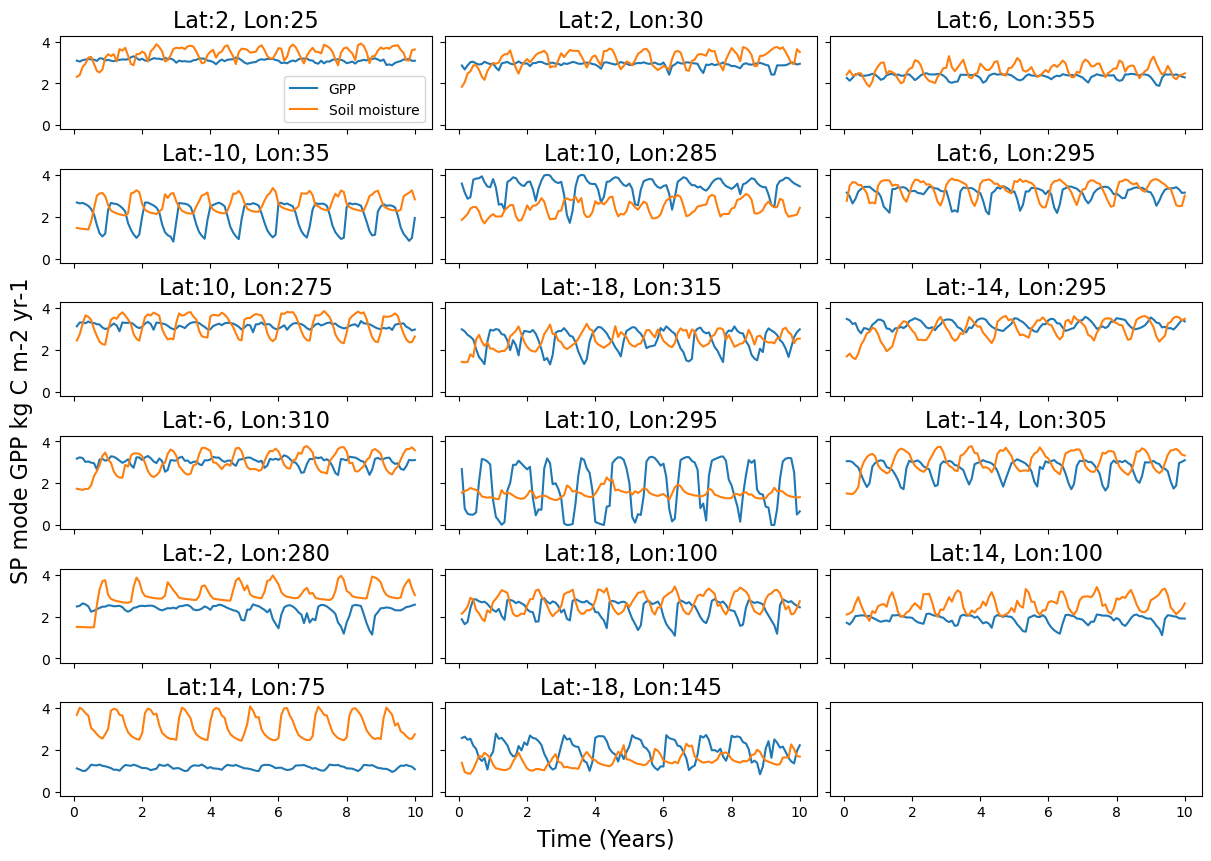

In [16]:
gpp_SP = fates_atkin_SP.FATES_GPP* 86400 * 365

gpp_SP = gpp_SP.sel(lat=lat_un,lon=lon_un)

fig, axs = plt.subplots(nrows=6,ncols=3,
                        figsize=(12,8.5), sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,17):
    axs[i].plot(time, gpp_SP[:,i], label = 'GPP')
    axs[i].plot(time, h2osoi[:,i], label = 'Soil moisture')
    axs[i].set_title(r'Lat:{0}, Lon:{1}'.format(w[i],z[i]), fontsize = 16)
    if i == 0 :
        axs[i].legend()
    
    
fig.supxlabel(r'Time (Years)', fontsize=16)
fig.supylabel(r'SP mode GPP kg C m-2 yr-1', fontsize=16)


### SP GPP by PFT

Text(0.02, 0.5, 'SP mode GPP kg C m-2 yr-1')

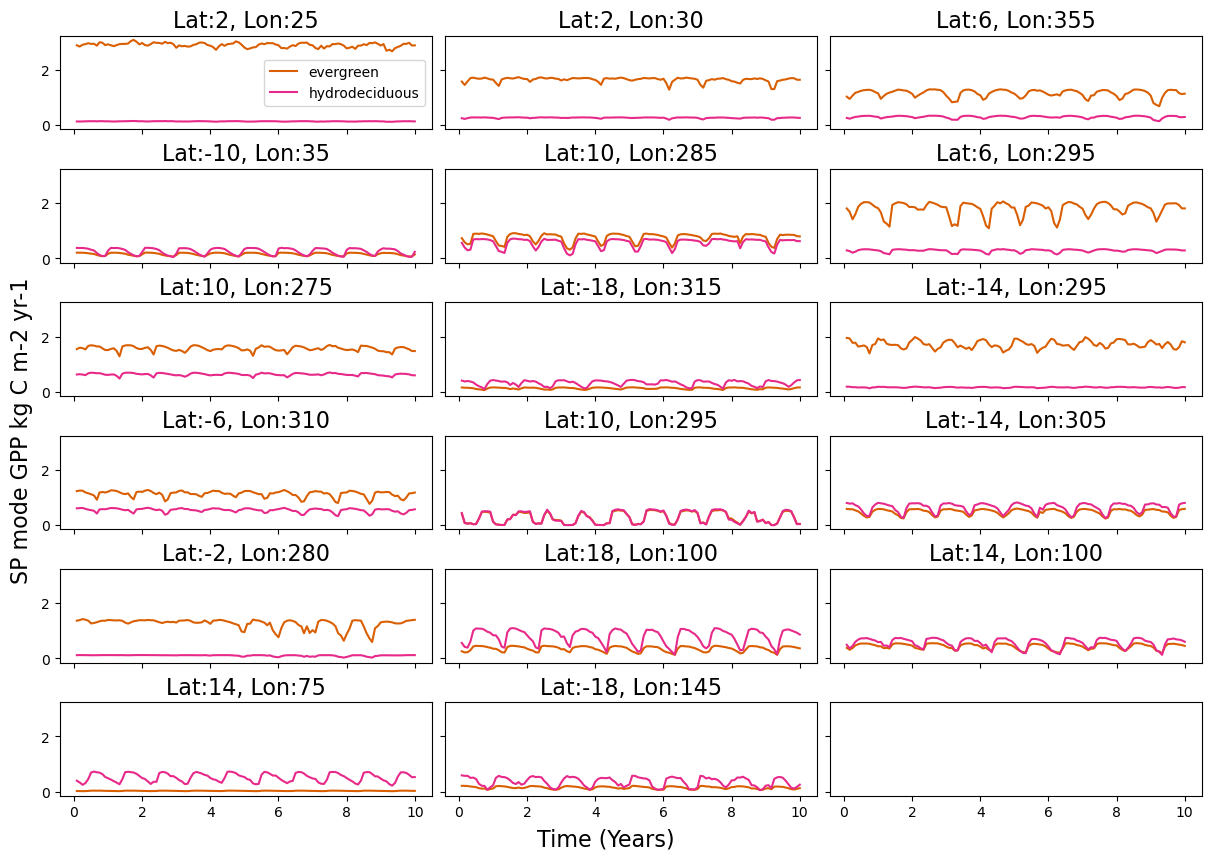

In [17]:
gpp_SP_PF = fates_atkin_SP.FATES_GPP_PF* 86400 * 365

gpp_SP_PF = gpp_SP_PF.sel(lat=lat_un,lon=lon_un)

gpp_SP_PF1 = gpp_SP_PF.isel(fates_levpft=0)
gpp_SP_PF5 = gpp_SP_PF.isel(fates_levpft=4)

fig, axs = plt.subplots(nrows=6,ncols=3,
                        figsize=(12,8.5), sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,17):
    axs[i].plot(time, gpp_SP_PF1[:,i], label ='evergreen', color=colormap[1])
    axs[i].plot(time, gpp_SP_PF5[:,i], label = 'hydrodeciduous', color=colormap[3])
    axs[i].set_title(r'Lat:{0}, Lon:{1}'.format(w[i],z[i]), fontsize = 16)
    if i == 0 :
        axs[i].legend()
   
    
fig.supxlabel(r'Time (Years)', fontsize=16)
fig.supylabel(r'SP mode GPP kg C m-2 yr-1', fontsize=16)


### Total GPP in SP mode v biomass in FBNC (year 10)

(0.0, 20.0)

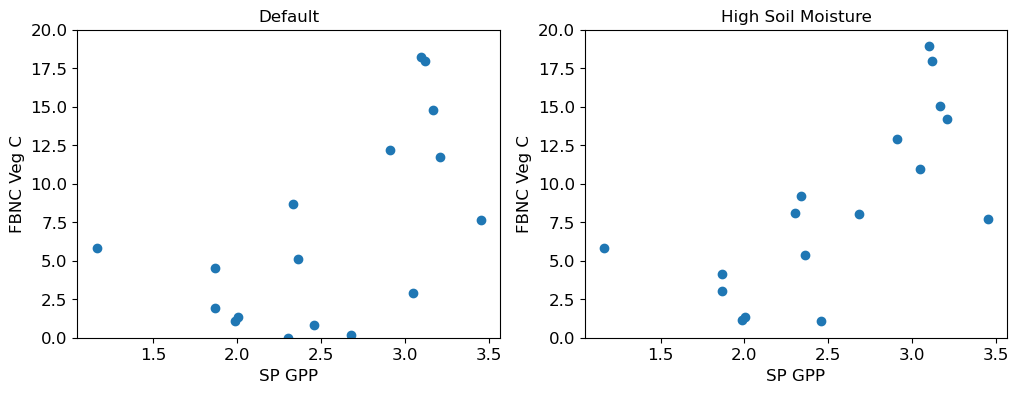

In [18]:
gpp_SP = fates_atkin_SP.FATES_GPP.mean('time')* 86400 * 365
gpp_SP = gpp_SP.sel(lat=lat_un,lon=lon_un)
 
vegc_FBNC = fates_atkin.FATES_VEGC.isel(time=slice(102,114)).mean(dim='time')
vegc_FBNC = vegc_FBNC.sel(lat=lat_un,lon=lon_un)

vegc_FBNC_v3 = fates_atkin_v3.FATES_VEGC.isel(time=slice(102,114)).mean(dim='time')
vegc_FBNC_v3 = vegc_FBNC_v3.sel(lat=lat_un,lon=lon_un)


fig2, ((f2ax0, f2ax1)) = plt.subplots(nrows=1,ncols=2, figsize=(12,4))

f2ax0.scatter(gpp_SP, vegc_FBNC)
f2ax0.set_title(r'Default', fontsize = 12)
f2ax0.set_ylabel(r'FBNC Veg C', fontsize = 12)
f2ax0.set_xlabel(r'SP GPP', fontsize = 12)
f2ax0.tick_params(labelsize=12)
f2ax0.set_ylim(0,20)

f2ax1.scatter(gpp_SP, vegc_FBNC_v3)
f2ax1.set_title(r'High Soil Moisture', fontsize = 12)
f2ax1.set_ylabel(r'FBNC Veg C', fontsize = 12)
f2ax1.set_xlabel(r'SP GPP', fontsize = 12)
f2ax1.tick_params(labelsize=12)
f2ax1.set_ylim(0,20)               

(0.0, 20.0)

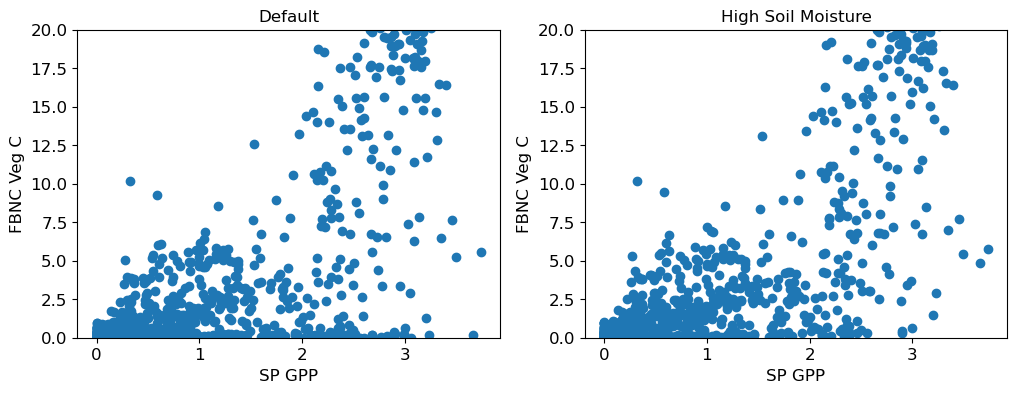

In [19]:
gpp_SP = fates_atkin_SP.FATES_GPP.mean('time')* 86400 * 365
#gpp_SP = gpp_SP.sel(lat=lat_un,lon=lon_un)
 
vegc_FBNC = fates_atkin.FATES_VEGC.isel(time=slice(102,114)).mean(dim='time')
#vegc_FBNC = vegc_FBNC.sel(lat=lat_un,lon=lon_un)

vegc_FBNC_v3 = fates_atkin_v3.FATES_VEGC.isel(time=slice(102,114)).mean(dim='time')
#vegc_FBNC_v3 = vegc_FBNC_v3.sel(lat=lat_un,lon=lon_un)


fig2, ((f2ax0, f2ax1)) = plt.subplots(nrows=1,ncols=2, figsize=(12,4))

f2ax0.scatter(gpp_SP, vegc_FBNC)
f2ax0.set_title(r'Default', fontsize = 12)
f2ax0.set_ylabel(r'FBNC Veg C', fontsize = 12)
f2ax0.set_xlabel(r'SP GPP', fontsize = 12)
f2ax0.tick_params(labelsize=12)
f2ax0.set_ylim(0,20)

f2ax1.scatter(gpp_SP, vegc_FBNC_v3)
f2ax1.set_title(r'High Soil Moisture', fontsize = 12)
f2ax1.set_ylabel(r'FBNC Veg C', fontsize = 12)
f2ax1.set_xlabel(r'SP GPP', fontsize = 12)
f2ax1.tick_params(labelsize=12)
f2ax1.set_ylim(0,20)               